# GAN 教學筆記本
首先需要大略瞭解生成式對抗網路的運作模式，需要被訓練的深度學習模型一共有兩個，一個是生成網路(Generator network)及監督網路(Discriminator network)。訓練目標是讓生成網路產生可以混淆監督網路的輸出。

## GAN 常被用於：
* 資料擴增：當資料不足時，可以藉由生成網路產生和訓練資料相似的資料，以此達成資料擴增的任務。
* 風格化產生器：藉由生成網路產生與輸入風格不同的圖片，該應用常用於人臉化粧、場景風格轉換。
* 產生遊戲AI：生成網路藉由學習玩家的遊戲習慣，產生遊戲行為，並經由辨析網路辨識真人或是遊戲AI，以此產生具有人類思考模式的遊戲AI。

在這本筆記本中，將學習生成式對抗網路(GAN)的基本概念。我們將利用手寫數字資料庫MNIST進行訓練，讓生成網路產生擬真數字資料混淆監督網路。

![LSTM](./utils/notebook_pic/GAN.png)


## 程式語言及相關的Library
* Python 
* Numpy
* Pytorch
* matplotlib

# 1. 導入相關的Library

In [1]:
%matplotlib inline

import os
import torch
import torchvision
from torch.autograd import Variable
import numpy as np
import itertools
import math
import time
import matplotlib.pyplot as plt
from IPython import display

# 2. 導入 MNIST資料集
簡介：MNIST資料集是由Yann LeCun收集而成，資料集包含圖片與標籤。在其中，訓練資料一共有60000筆，而測試資料共10000筆。每一筆資料的照片是由 28像素 x 28像素，總共 784 個 pixels 所組成，圖片顯示的是0到9之中的一個阿拉伯數字。資料的標籤則表示該手寫數字圖片所呈現的數字為何，也就是 0 到 9 中一個數值。
![MNIST](./utils/notebook_pic/MNIST.jpeg)


In [2]:
import torchvision.transforms as transforms
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

# 3. 定義生成網路、監督網路
## 生成網路：
生成網路的目標是要偽造圖片，輸入至生成網路是一個隨機數。根據不同的隨機輸入數輸出不同的圖片，而若是生成網路訓練地非常完美，生成網路就可以不斷地輸出跟真實手寫數字相差無幾的圖片。
## 監督網路：
監督網路的目標就是要分辨資料的來源，給監督網路一張手寫圖片，計算出「相似度」的分數，分數越高則表示這張手寫圖片是來自真的資料集，反之則是由生成網路偽造的。



In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x)
        return out

discriminator = Discriminator().cuda()
generator = Generator().cuda()

print("監督網路之結構 ： ")
print(discriminator)
print("生成網路之結構 ： ")
print(generator)

監督網路之結構 ： 
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Dropout(p=0.3)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Dropout(p=0.3)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Dropout(p=0.3)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)
生成網路之結構 ： 
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)


# 4. 設定訓練細節
* 訓練次數 : 預設為10
* 設定Loss function : 預設為Binary Cross-Entropy Loss
* 設定Optimizer : 預設為Adam
* 設定測試用雜訊 : 預設為16組隨機雜訊

## Loss Function補充說明
![Loss_gan](./utils/notebook_pic/loss.png)

可以藉由Loss Function了解到對抗式學習的原理，我們希望生成網路生成的圖片與真實圖片差距越小越好。此外，監督網路必須盡可能辨別來源。對抗式學習的精神就在於，迫使生成網路產生足以混淆監督網路的圖片、促使監督網路必須精準的辨識圖片來源。

In [4]:
import torch.optim as optim

EPOCH = 10
criterion = nn.BCELoss()
lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
test_noise = Variable(torch.randn(16, 100).cuda())
num_batches = len(train_loader)
num_fig = 0

def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    """
    訓練監督網路的函式
    """
    discriminator.zero_grad()
    #輸入真實圖片
    outputs = discriminator(images)
    #比對來源，計算Loss
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    #輸入生成圖片
    outputs = discriminator(fake_images) 
    #比對來源，計算Loss
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs
    #加總Loss
    d_loss = real_loss + fake_loss
    #修正網路並調整Optimizer
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

def train_generator(generator, discriminator_outputs, real_labels):
    """
    訓練生成網路的函式
    """
    generator.zero_grad()
    #計算生成圖片與真實圖片之差距
    g_loss = criterion(discriminator_outputs, real_labels)
    #修正網路並調整Optimizer
    g_loss.backward()
    g_optimizer.step()
    return g_loss




# 5. 進行訓練/輸出結果

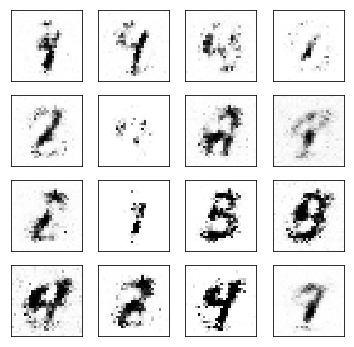

Epoch [10/10], Step[600/600], d_loss: 0.3591, g_loss: 2.6153, D(x): 0.85, D(G(z)): 0.10
結束訓練


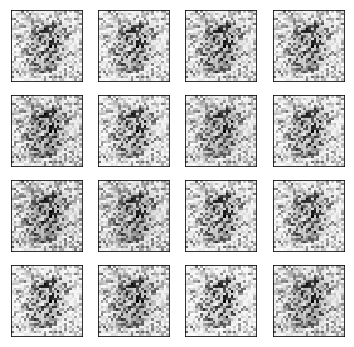

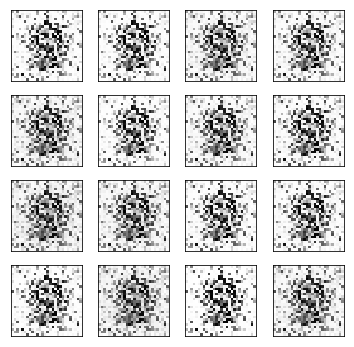

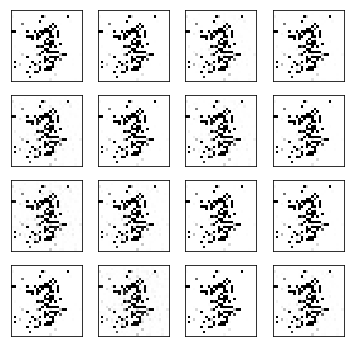

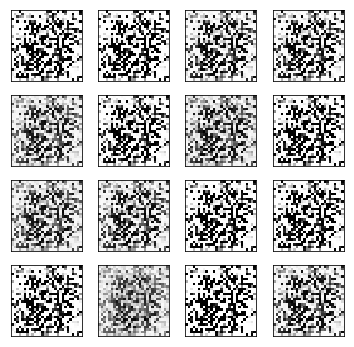

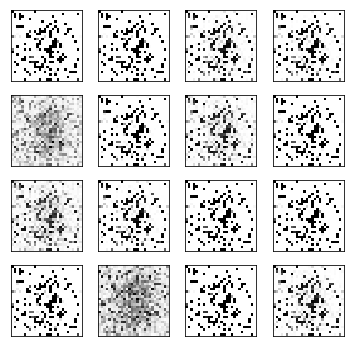

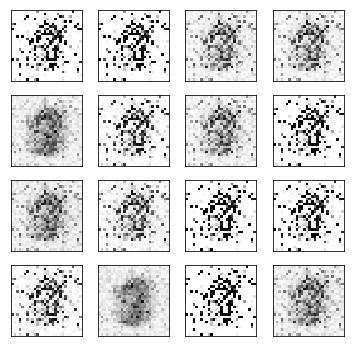

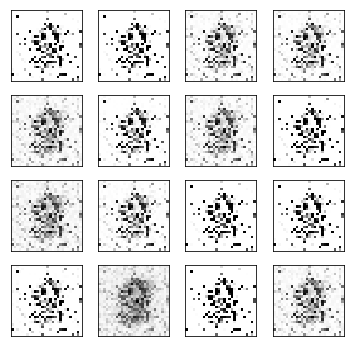

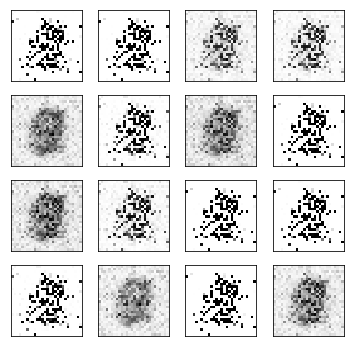

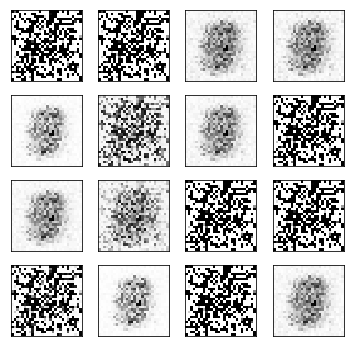

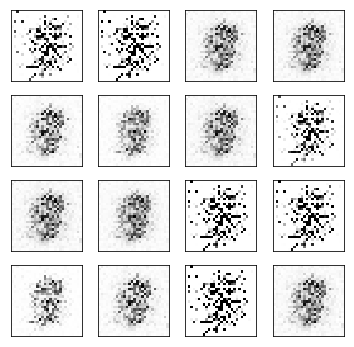

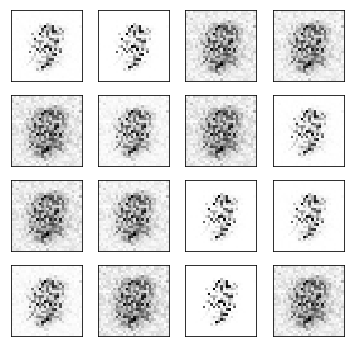

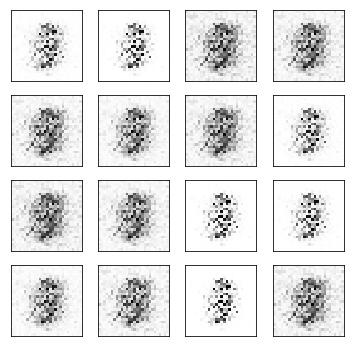

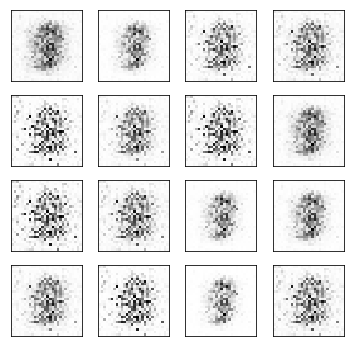

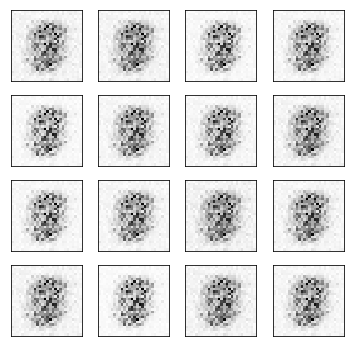

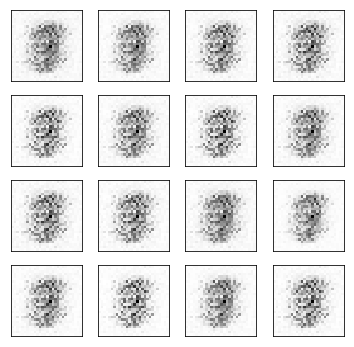

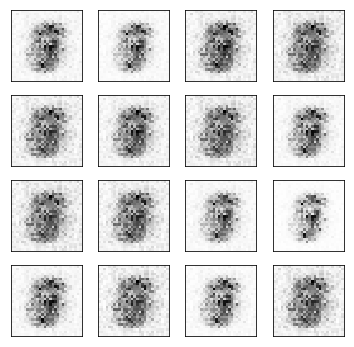

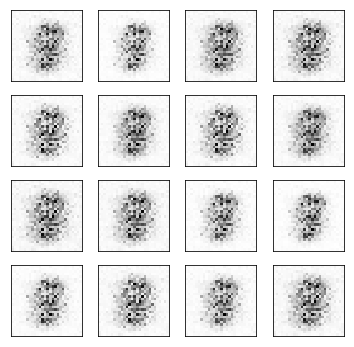

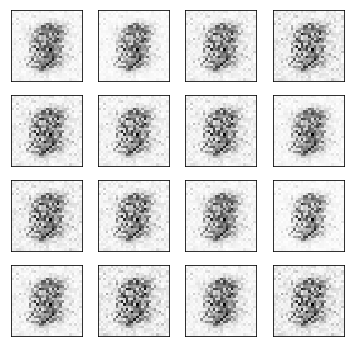

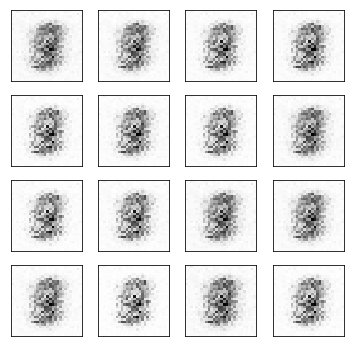

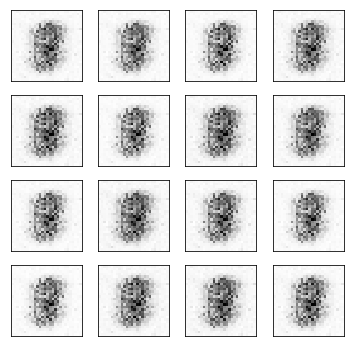

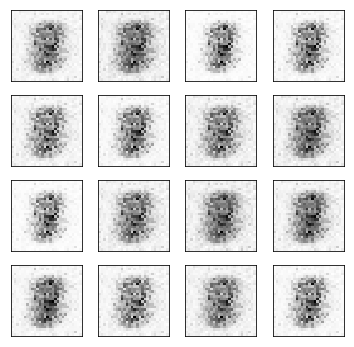

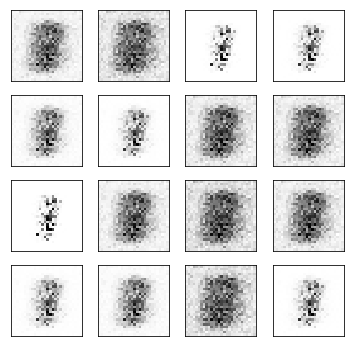

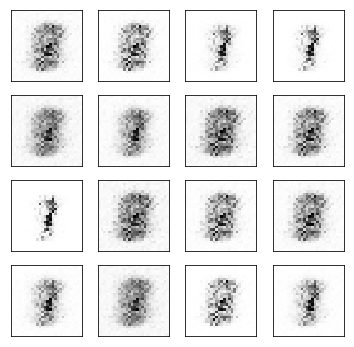

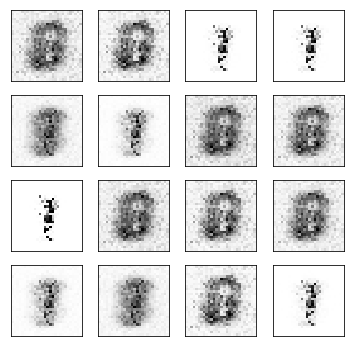

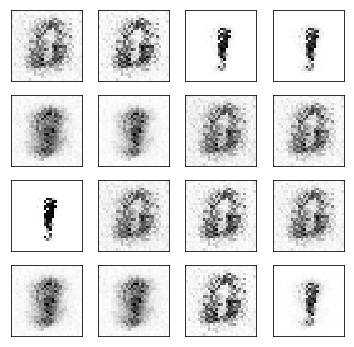

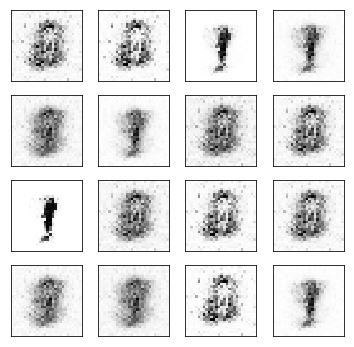

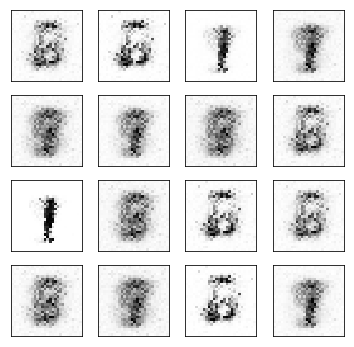

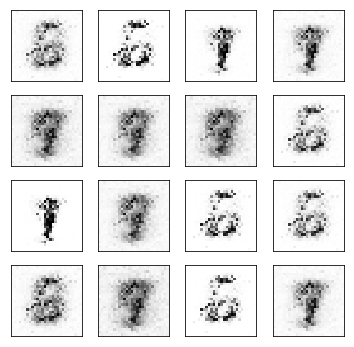

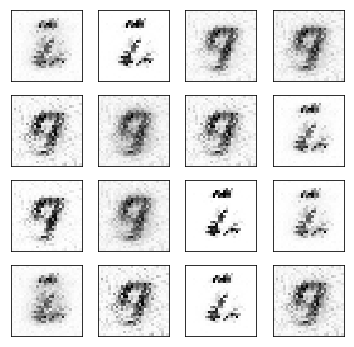

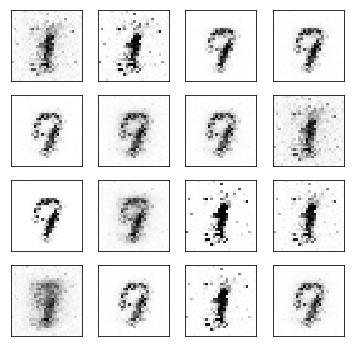

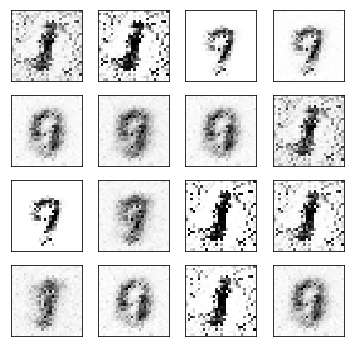

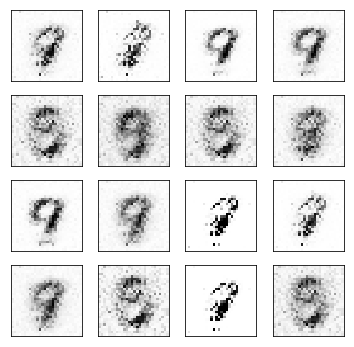

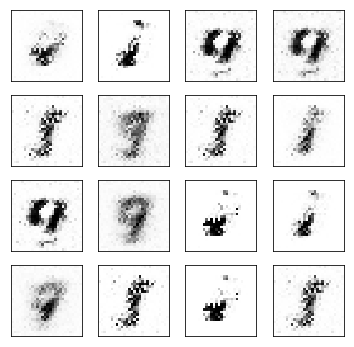

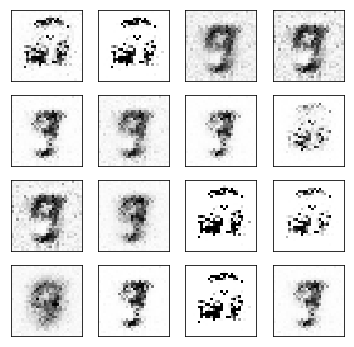

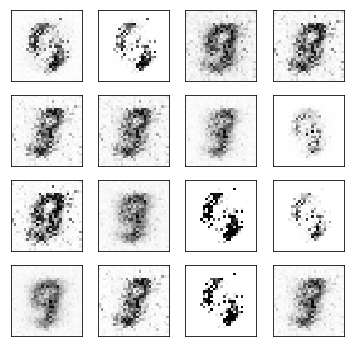

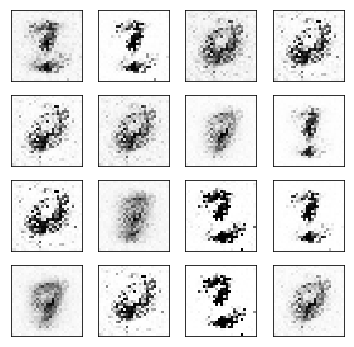

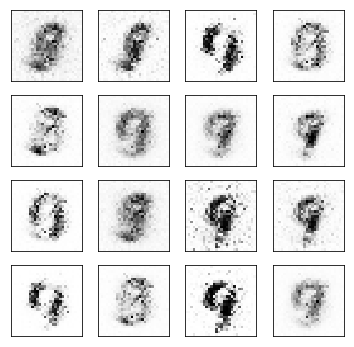

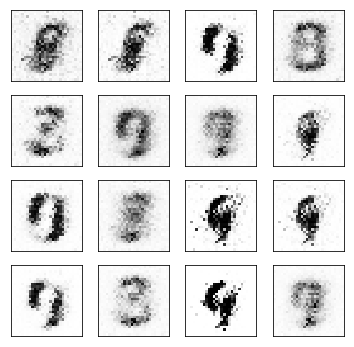

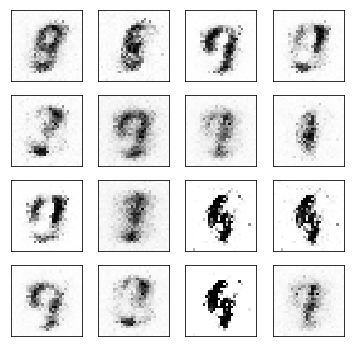

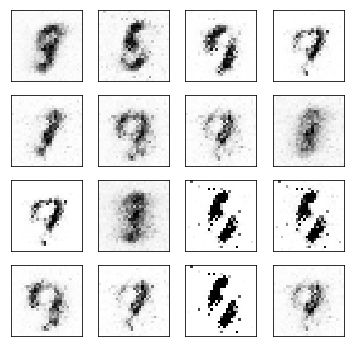

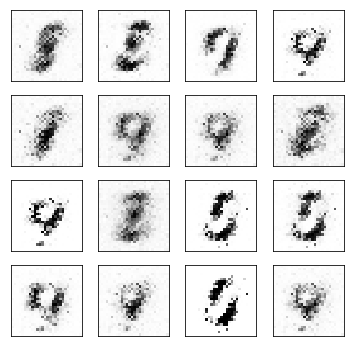

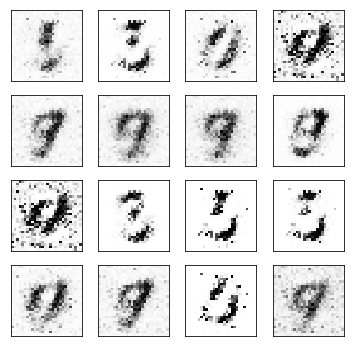

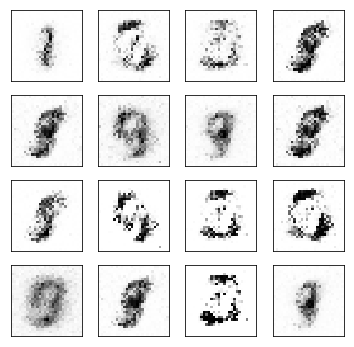

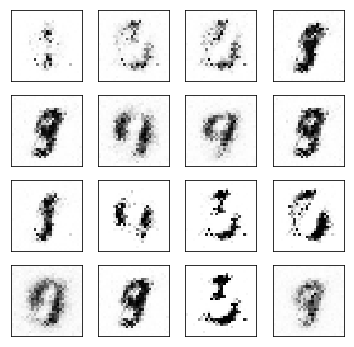

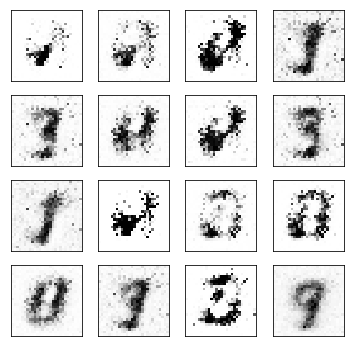

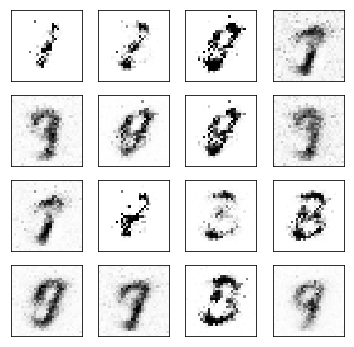

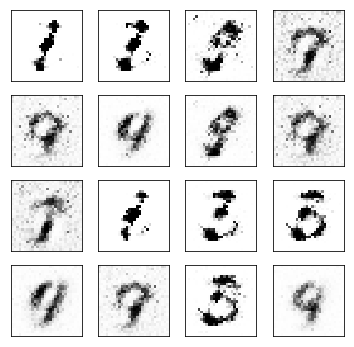

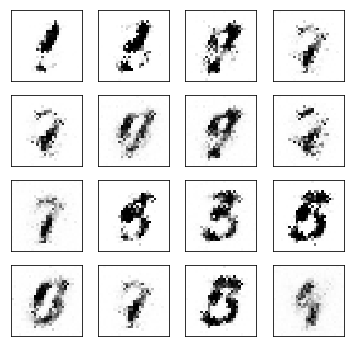

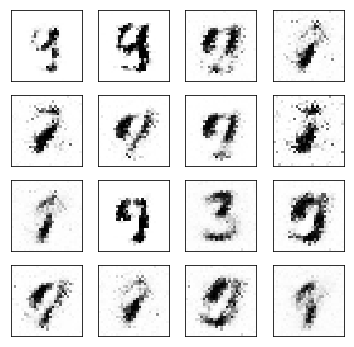

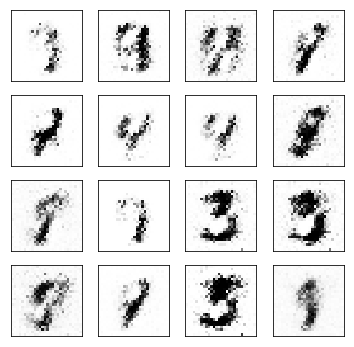

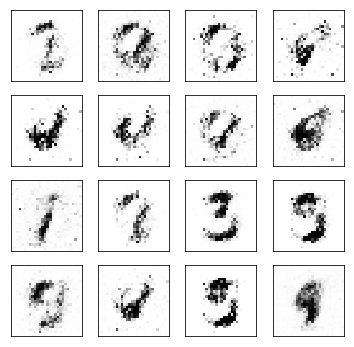

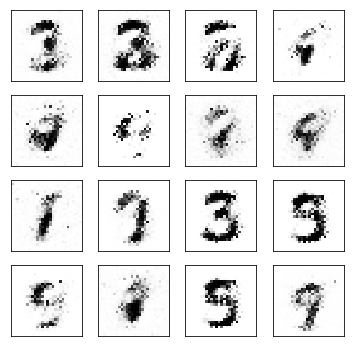

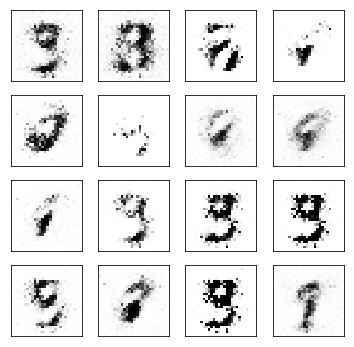

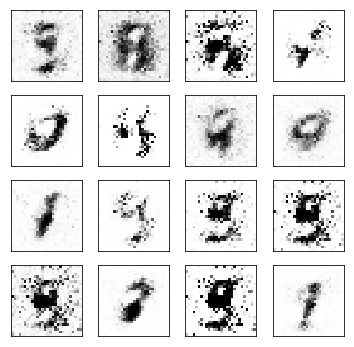

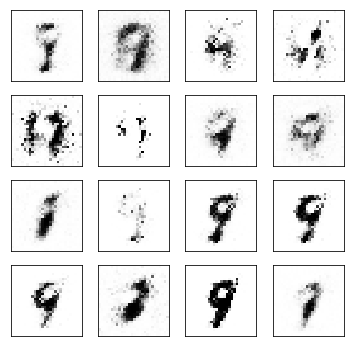

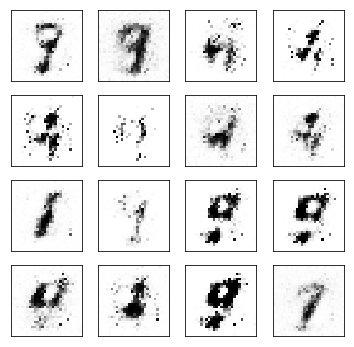

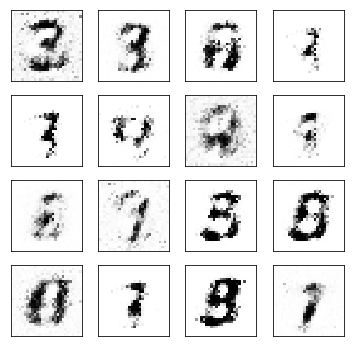

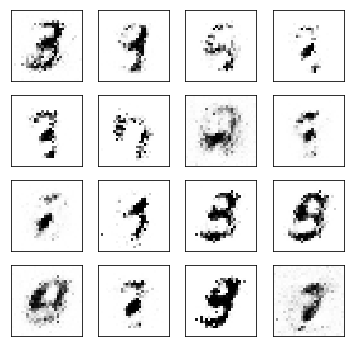

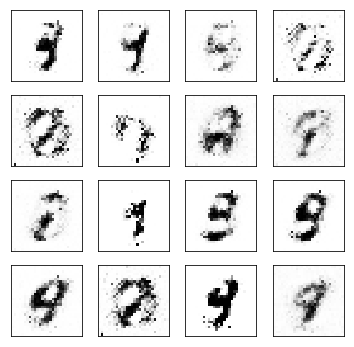

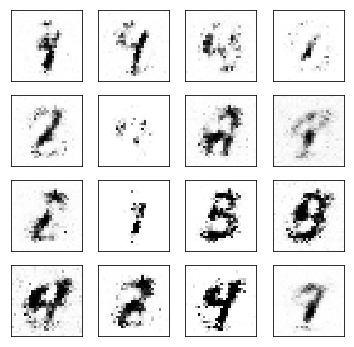

In [5]:
for epoch in range(EPOCH):
    for n, (images, _) in enumerate(train_loader):
        images = Variable(images.cuda())
        real_labels = Variable(torch.ones(images.size(0)).cuda())
        #隨機生成雜訊
        noise = Variable(torch.randn(images.size(0), 100).cuda())
        #藉由計算監督網路辨識來源
        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0)).cuda())
        #訓練辨識網路
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        #隨機生成雜訊
        noise = Variable(torch.randn(images.size(0), 100).cuda())
        #介由隨機生成雜訊取得生成圖片
        fake_images = generator(noise)
        #藉由計算監督網路辨識來源
        outputs = discriminator(fake_images)
        #訓練生成網路
        g_loss = train_generator(generator, outputs, real_labels)
        #每100步，輸出當前圖片
        if (n+1) % 100 == 0:
            test_images = generator(test_noise)
            size_figure_grid = int(math.sqrt(16))
            
            fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
            for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
                ax[i,j].get_xaxis().set_visible(False)
                ax[i,j].get_yaxis().set_visible(False)
            
            for k in range(16):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            #plt.savefig('results/mnist-gan-%03d.png'%num_fig)
            num_fig += 1
            
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
                  'D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch + 1, EPOCH, n+1, num_batches, d_loss.data[0], g_loss.data[0],
                    real_score.data.mean(), fake_score.data.mean()))


print('結束訓練')

# 訓練200 EPOCH 後的細節
![200epoch](./utils/notebook_pic/200.png)
Epoch [200/200], Step[600/600], d_loss: 1.2648, g_loss: 0.8531, D(x): 0.57, D(G(z)): 0.45